In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), ".")))

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # Go up one


# Clean up duplicate paths
sys.path = [path for path in sys.path if path != '/home/fcufino/SimpleSparseCNN']
sys.path = [path for path in sys.path if path != '/home/fcufino/faserDL']

# Insert the correct path at the beginning
sys.path.insert(0, '/home/fcufino/SimpleSparseCNN')

# Check the sys.path again
print(sys.path)


['/home/fcufino/SimpleSparseCNN', '/home/fcufino/SimpleSparseCNN/test', '/scratch/fcufino/conda_envs/convnextv2/lib/python310.zip', '/scratch/fcufino/conda_envs/convnextv2/lib/python3.10', '/scratch/fcufino/conda_envs/convnextv2/lib/python3.10/lib-dynload', '', '/scratch/fcufino/conda_envs/convnextv2/lib/python3.10/site-packages', '/scratch/fcufino/conda_envs/convnextv2/lib/python3.10/site-packages/setuptools/_vendor', '/scratch/fcufino/conda_envs/convnextv2/lib/python3.10/site-packages/MinkowskiEngine-0.5.4-py3.10-linux-x86_64.egg', '/home/fcufino/SimpleSparseCNN/test']


In [2]:
import sys
import os
import torch
import torch.nn as nn
import MinkowskiEngine as ME
import matplotlib.pyplot as plt
from utils.funcs import *
from dataset.dataset import XYProjectionFASERCALDataset
from model.networkAttention import MinkEncClsConvNeXtV2  # adjust path if needed

from types import SimpleNamespace


# Setup arguments for dataset and model
args = SimpleNamespace()
args.dataset_path = "/scratch/salonso/sparse-nns/faser/events_v5.1"
args.sets_path = "/scratch/salonso/sparse-nns/faser/events_v5.1/sets.pkl"
args.batch_size = 32
args.num_workers = 4
args.augmentations_enabled = False  
args.train = False  # Set to False since we're only testing
args.stage1 = False

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Make only GPU A100 visible


# Init dataset
dataset = XYProjectionFASERCALDataset(args)
print("- Dataset size: {} events".format(len(dataset)))

train_loader, valid_loader, test_loader = split_dataset(dataset, args, splits=[0.6, 0.1, 0.3], test=True) 

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MinkEncClsConvNeXtV2(in_channels=1, out_channels=4, args=args).to(device)

# Load the saved model
model.load_state_dict(torch.load("/home/fcufino/SimpleSparseCNN/best_model_noAtt.pth"))
model.eval()  # Set the model to evaluation mode

# Loss function (optional, just for evaluation purposes)
loss_fn = nn.CrossEntropyLoss()

/scratch/fcufino/conda_envs/convnextv2/lib/python3.10/site-packages/MinkowskiEngine-0.5.4-py3.10-linux-x86_64.egg/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


- Dataset size: 111994 events
Loaded saved splits!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

print("\nRunning inference on test set...")

# Prepare accumulators
all_images = []
all_predictions = []
all_true_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running Inference"):
        # Move batch data to device
        batch_input, batch_input_global = arrange_sparse_minkowski(batch, device)

        # Forward pass
        outputs = model(batch_input, batch_input_global)
        predictions = outputs['out_flavour'].cpu()

        # Get predicted classes
        _, predicted_classes = torch.max(predictions, 1)

        # Store true labels
        true_labels = batch['flavour_label']

        # Get image coords and features (grayscale)
        coords = batch_input.C.cpu().numpy()  # MinkowskiEngine uses .C for coords
        feats = batch_input.F.cpu().numpy().flatten()  # and .F for features


        # Reconstruct full 2D image per sample in the batch
        batch_size = 32
        for i in range(batch_size):
            # Get pixels belonging to image i
            mask = coords[:, 0] == i
            img_coords = coords[mask][:, 1:]  # drop batch_idx
            img_feats = feats[mask]

            # Determine image size 
            h = img_coords[:, 0].max() + 1
            w = img_coords[:, 1].max() + 1
            img = np.zeros((h, w))

            for coord, feat in zip(img_coords, img_feats):
                y, x = coord  # Assuming [y, x] for 2D
                img[y, x] = np.log(feat)

            all_images.append(img)
            all_predictions.append(predicted_classes[i].item())
            all_true_labels.append(true_labels[i].item())

            if len(all_images) >= 200:
                break

        if len(all_images) >= 200:
            break  # Only collect first 200 total



Running inference on test set...


Running Inference:   1%|          | 6/1050 [00:05<15:16,  1.14it/s]


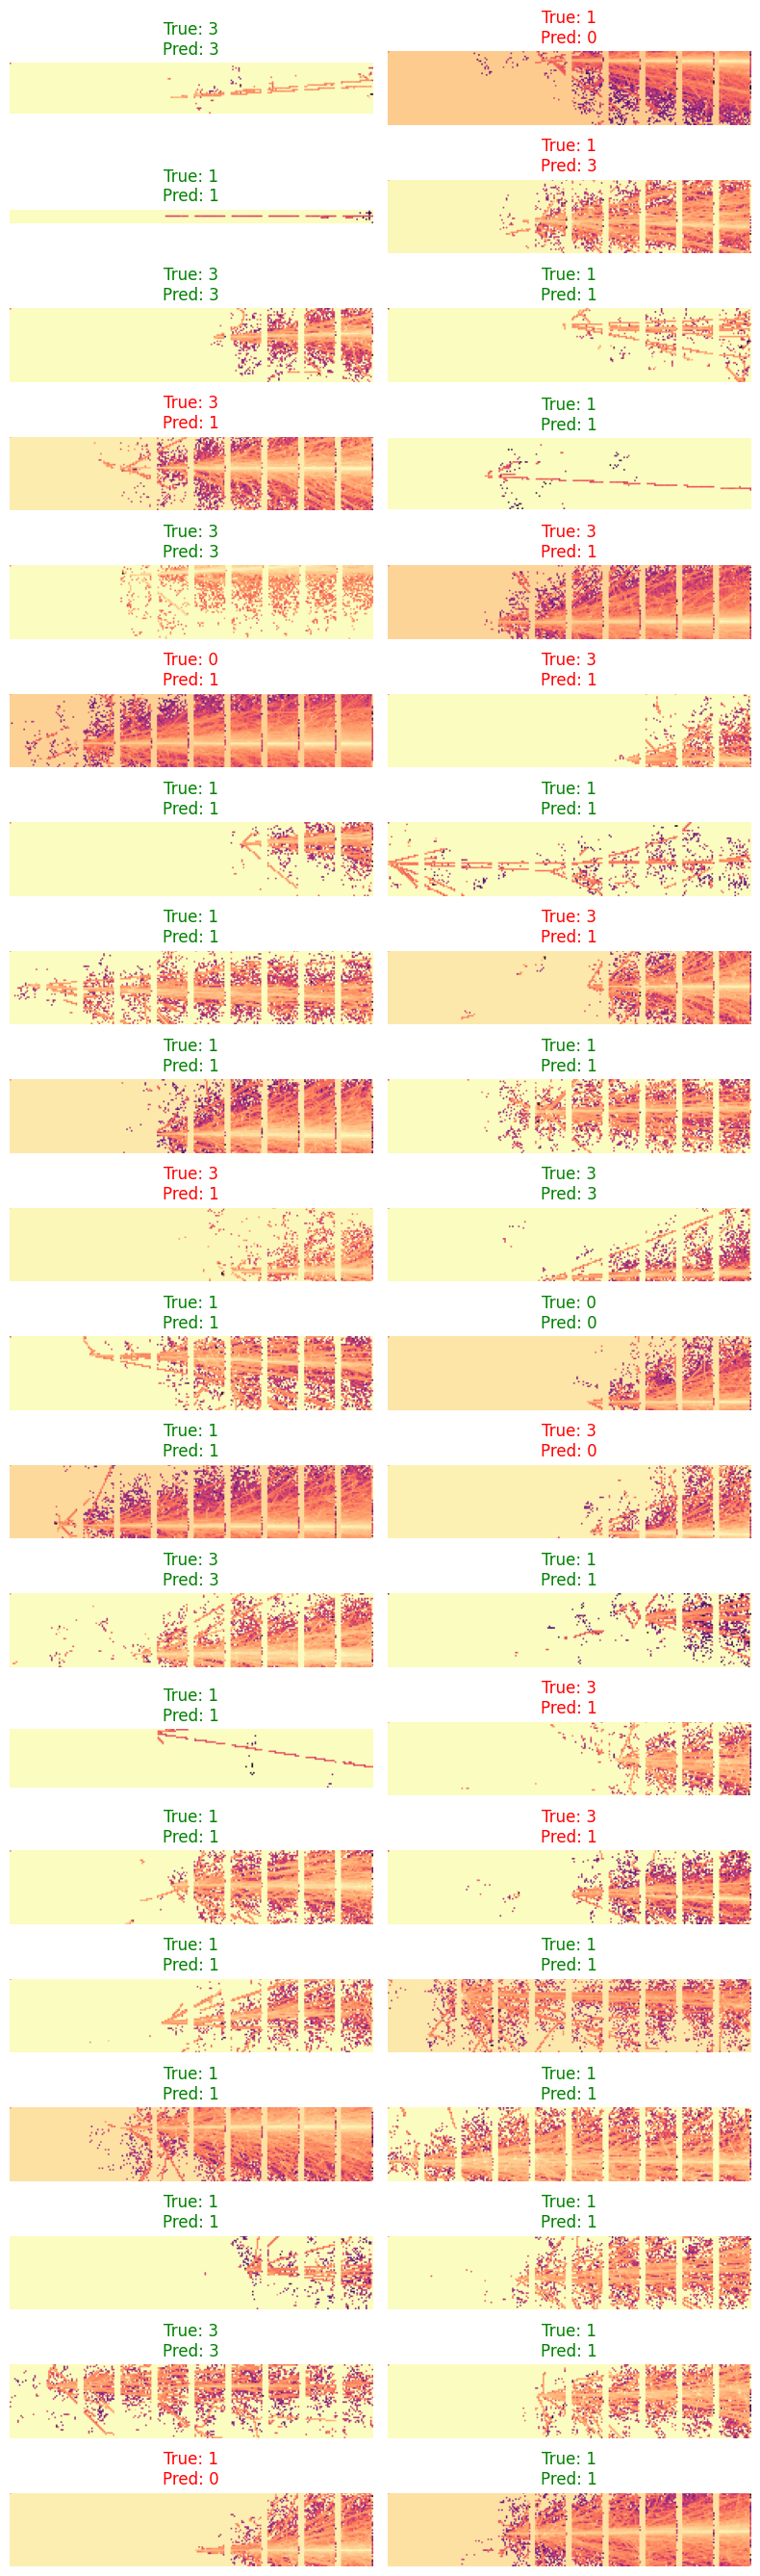

In [4]:
# Plot 20 images with true and predicted labels vs true per true class
fig, axes = plt.subplots(20, 2, figsize=(8, 27))
axes = axes.flatten()

for i in range(40):
    img = all_images[i]
    axes[i].imshow(img, cmap='magma')
    axes[i].axis('off')
    # Set title with color indicating whether the label is correct or not
    axes[i].set_title(f"True: {all_true_labels[i]}\nPred: {all_predictions[i]}", 
                      c='red' if all_true_labels[i] != all_predictions[i] else 'green')

plt.tight_layout()
plt.show()


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

print("\nRunning inference on full test set...")

# Prepare accumulators
all_predictions = []
all_true_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Running Inference"):
        # Move batch data to device
        batch_input, batch_input_global = arrange_sparse_minkowski(batch, device)

        # Forward pass
        outputs = model(batch_input, batch_input_global)
        predictions = outputs['out_flavour'].cpu()

        # Get predicted classes
        _, predicted_classes = torch.max(predictions, 1)

        # Store predictions and true labels
        true_labels = batch['flavour_label']  # list of tensors

        # Extend predictions
        all_predictions.extend(predicted_classes.numpy())

        # Convert list of tensors to list of ints
        true_label_values = [label.item() if isinstance(label, torch.Tensor) else label for label in true_labels]
        all_true_labels.extend(true_label_values)



Running inference on full test set...


Running Inference: 100%|██████████| 1050/1050 [02:59<00:00,  5.84it/s]


In [6]:
import numpy as np

# Flatten lists into 1D arrays
preds = np.array(all_predictions).flatten()
trues = np.array(all_true_labels).flatten()

# Now, safely get unique classes
classes = sorted(set(trues) | set(preds))
num_classes = len(classes)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

# Initialize confusion matrix
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Fill confusion matrix
for true, pred in zip(trues, preds):
    i = class_to_idx[true]
    j = class_to_idx[pred]
    conf_matrix[i, j] += 1

# Print confusion matrix
print("\nConfusion Matrix:")
header = " " * 10 + " ".join([f"{cls:>5}" for cls in classes])
print(header)
print("-" * len(header))

for i, row in enumerate(conf_matrix):
    row_str = f"{classes[i]:<10}" + " ".join([f"{val:>5}" for val in row])
    print(row_str)

# Accuracy per class calculation and printing
print("\nAccuracy per class:")
for i, cls in enumerate(classes):
    true_positives = conf_matrix[i, i]
    total_samples = np.sum(conf_matrix[i])
    accuracy = true_positives / total_samples if total_samples > 0 else 0
    print(f"Class {cls}: {accuracy:.4f}")



# Accuracy overall
total_true_positives = np.sum(np.diag(conf_matrix))
total_samples = np.sum(conf_matrix)
overall_accuracy = total_true_positives / total_samples if total_samples > 0 else 0

# Print overall accuracy
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")


Confusion Matrix:
              0     1     2     3
---------------------------------
0          2303  1129     0   809
1           436 18934     0  1488
2             4    11     0    43
3           504  2951     0  4987

Accuracy per class:
Class 0: 0.5430
Class 1: 0.9078
Class 2: 0.0000
Class 3: 0.5907

Overall Accuracy: 0.7805



## No Attention Best Mdoel 

```bash
Confusion Matrix:
              0     1     2     3
---------------------------------
0          2303  1129     0   809
1           436 18934     0  1488
2             4    11     0    43
3           504  2951     0  4987

Accuracy per class:
Class 0: 0.5430
Class 1: 0.9078
Class 2: 0.0000
Class 3: 0.5907

Overall Accuracy: 0.7805